## **Reading the Dataset as a DataFrame**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Final Year Paper Work/Complete Summarized Dataset.xlsx', header=0,index_col=0)

df = df.dropna() # To remove any None values
df.head()

,Judgement,Domain,Judgement Status,Court,Abstractive Summarized Judgements,Extractive Summarized Judgements
Id,,,,,,
1,"""This was an appeal from a judgment and decree...",Civil,1,Supreme Court,In order to enforce war-time controls another ...,"According to the Respondent, on the 11th Augus..."
2,"""This was an application under article 32 (1) ...",Civil,2,Supreme Court,The second part of this bye-law clearly contem...,This is an application under article 32 of the...
3,"""APPEAL from a judgment of the High Court of H...",Civil,0,Supreme Court,The learned advocate for the appellant contend...,749 The sole point for determination in the ap...
4,"""APPEAL under article 374(4) of the Constituti...",Civil,0,Supreme Court,It has been held that the first appellate cour...,This objection was overruled by the court and ...
5,"""Petitions under Art. 136 of the Constitution ...",Criminal,3,Supreme Court,It was pointed out that in respect of convicti...,The petitioners have now filed their petitions...


##**Splitting the data for complete, extractive and abstractive summarized texts**

In [ ]:
# Complete Data
com_sentences = df[['Judgement','Judgement Status']]

# Abstractive Data
abs_sentences = df[['Abstractive Summarized Judgements','Judgement Status']]

# Extractive Data
ext_sentences = df[['Extractive Summarized Judgements','Judgement Status']]

from sklearn.model_selection import train_test_split

# Train and Test Split for Complete Data
df_train_com, df_test_com = train_test_split(com_sentences, test_size=0.25, random_state=42)

# Train and Test Split for Abstractive Data
df_train_abs, df_test_abs = train_test_split(abs_sentences, test_size=0.25, random_state=42)

# Train and Test Split for Extractive Data
df_train_ext, df_test_ext = train_test_split(ext_sentences, test_size=0.25, random_state=42)

## **Converting the Judgement Status to Categorical Values**

In [ ]:
from tensorflow.keras.utils import to_categorical

# Complete Data
y_train_com = to_categorical(df_train_com['Judgement Status'])
y_test_com = to_categorical(df_test_com['Judgement Status'])

# Abstractive Data
y_train_abs = to_categorical(df_train_abs['Judgement Status'])
y_test_abs = to_categorical(df_test_abs['Judgement Status'])

# Extractive Data
y_train_ext = to_categorical(df_train_ext['Judgement Status'])
y_test_ext = to_categorical(df_test_ext['Judgement Status'])

## **Import Statements**

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.6 MB/s eta 0:00:00


In [ ]:
# Import Statements
import tensorflow as tf
from tensorflow import keras
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Load the tokenizer and model
lbert_tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
lbert_model = TFAutoModelForSequenceClassification.from_pretrained("nlpaueb/legal-bert-base-uncased", num_labels=4)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##**1) Complete Data**

In [ ]:
# Tokenize the input (takes some time)
# here tokenizer using from bert-base-cased
x_train_com_lbert = lbert_tokenizer(
    text=df_train_com['Judgement'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test_com_lbert = lbert_tokenizer(
    text=df_test_com['Judgement'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids_com_lbert = x_train_com_lbert['input_ids']
attention_mask_com_lbert = x_train_com_lbert['attention_mask']

In [ ]:
max_len = 100

input_ids_com_lbert = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask_com_lbert = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = lbert_model(input_ids_com_lbert, attention_mask = input_mask_com_lbert)[0]
out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)

model_com_lbert = tf.keras.Model(inputs=[input_ids_com_lbert, input_mask_com_lbert], outputs=y)
model_com_lbert.layers[2].trainable = True

In [ ]:
optimizer_com_lbert = tf.keras.optimizers.legacy.Adam(learning_rate=5e-05, # this learning rate is for legal bert model , taken from huggingface website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss_com_lbert = CategoricalCrossentropy(from_logits = True)
metric_com_lbert = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model_com_lbert.compile(
    optimizer = optimizer_com_lbert,
    loss=loss_com_lbert,
    metrics = metric_com_lbert)

In [ ]:
history_com_lbert = model_com_lbert.fit(
    x ={'input_ids':x_train_com_lbert['input_ids'],'attention_mask':x_train_com_lbert['attention_mask']} ,
    y = y_train_com,
    validation_data = (
    {'input_ids':x_test_com_lbert['input_ids'],'attention_mask':x_test_com_lbert['attention_mask']}, y_test_com
    ),
  epochs=10,
    batch_size=64
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 83s 2s/step - loss: 1.3868 - balanced_accuracy: 0.2748 - val_loss: 1.3726 - val_balanced_accuracy: 0.3020
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 1.3674 - balanced_accuracy: 0.2995 - val_loss: 1.3533 - val_balanced_accuracy: 0.3020
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 1.3296 - balanced_accuracy: 0.4122 - val_loss: 1.3131 - val_balanced_accuracy: 0.4362
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 1.2835 - balanced_accuracy: 0.4527 - val_loss: 1.2809 - val_balanced_accuracy: 0.4362
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 1.2376 - balanced_accuracy: 0.4820 - val_loss: 1.2555 - val_balanced_accuracy: 0.4295
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 1.1995 - balanced_accuracy: 0.5045 - val_loss: 1.2374 - val_balanced_accuracy: 0.4228
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 1.145

In [ ]:
predicted_raw_com_lbert = model_com_lbert.predict({'input_ids':x_test_com_lbert['input_ids'],'attention_mask':x_test_com_lbert['attention_mask']})
predicted_raw_com_lbert[0]

5/5 [==============================] - 6s 200ms/step


array([0.47875658, 0.5265693 , 0.30382746, 0.4220776 ], dtype=float32)

In [ ]:
import numpy as np

y_predicted_com_lbert = np.argmax(predicted_raw_com_lbert, axis = 1)
y_true_com_lbert = df_test_com['Judgement Status']

In [ ]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_true_com_lbert, y_predicted_com_lbert))

print("F1 Score: ",f1_score(y_true_com_lbert,y_predicted_com_lbert, average='weighted'))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.43      0.91      0.59        45
           2       0.41      0.66      0.51        29
           3       0.50      0.11      0.18        36

    accuracy                           0.43       149
   macro avg       0.34      0.42      0.32       149
weighted avg       0.33      0.43      0.32       149

F1 Score:  0.319435776751213


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
x_train_com_lbert ={'input_ids':x_train_com_lbert['input_ids'],'attention_mask':x_train_com_lbert['attention_mask']}

train_loss_com_lbert, train_accuracy_com_lbert = model_com_lbert.evaluate(x_train_com_lbert, y_train_com, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy_com_lbert))

Training Accuracy: 0.6194


In [ ]:
x_test_com_lbert = {'input_ids':x_test_com_lbert['input_ids'],'attention_mask':x_test_com_lbert['attention_mask']}

test_loss_com_lbert, test_accuracy_com_lbert = model_com_lbert.evaluate(x_test_com_lbert, y_test_com, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_com_lbert))

Testing Accuracy:  0.4295


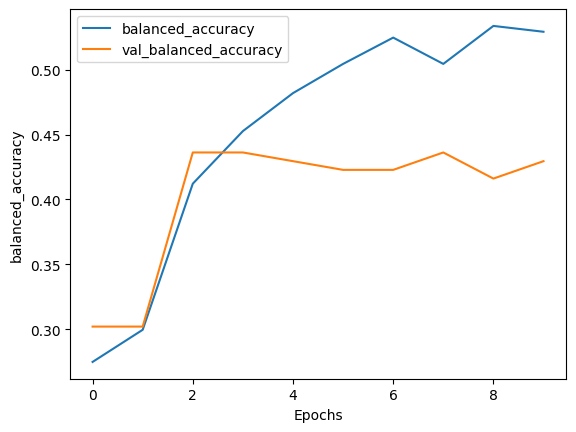

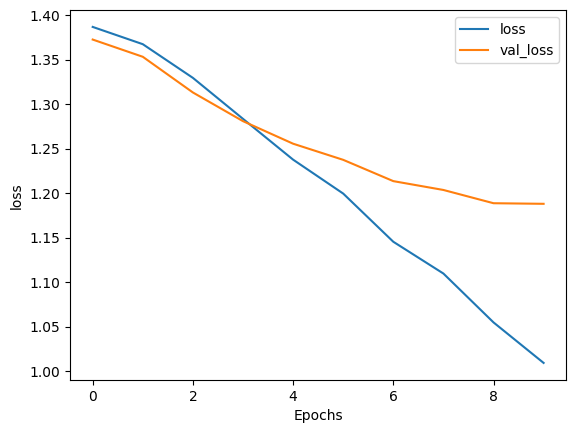

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_com_lbert, "balanced_accuracy")
plot_graphs(history_com_lbert, "loss")

In [ ]:
model_com_lbert.save("/content/drive/MyDrive/Final Year Paper Work/H5 Files/COM-LEGALBERT.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##**2) Abstractive Summarized Data**

In [ ]:
# Tokenize the input (takes some time)
# here tokenizer using from bert-base-cased
x_train_abs_lbert = lbert_tokenizer(
    text=df_train_abs['Abstractive Summarized Judgements'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test_abs_lbert = lbert_tokenizer(
    text=df_test_abs['Abstractive Summarized Judgements'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids_abs_lbert = x_train_abs_lbert['input_ids']
attention_mask_abs_lbert = x_train_abs_lbert['attention_mask']

In [ ]:
max_len = 100

input_ids_abs_lbert = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask_abs_lbert = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = lbert_model(input_ids_abs_lbert, attention_mask = input_mask_abs_lbert)[0]
out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)

model_abs_lbert = tf.keras.Model(inputs=[input_ids_abs_lbert, input_mask_abs_lbert], outputs=y)
model_abs_lbert.layers[2].trainable = True

In [ ]:
optimizer_abs_lbert = tf.keras.optimizers.legacy.Adam(learning_rate=5e-05, # this learning rate is for legal bert model , taken from huggingface website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss_abs_lbert = CategoricalCrossentropy(from_logits = True)
metric_abs_lbert = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model_abs_lbert.compile(
    optimizer = optimizer_abs_lbert,
    loss=loss_abs_lbert,
    metrics = metric_abs_lbert)

In [ ]:
history_abs_lbert = model_abs_lbert.fit(
    x ={'input_ids':x_train_abs_lbert['input_ids'],'attention_mask':x_train_abs_lbert['attention_mask']} ,
    y = y_train_abs,
    validation_data = (
    {'input_ids':x_test_abs_lbert['input_ids'],'attention_mask':x_test_abs_lbert['attention_mask']}, y_test_abs
    ),
  epochs=10,
    batch_size=64
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 67s 2s/step - loss: 1.4634 - balanced_accuracy: 0.2523 - val_loss: 1.3855 - val_balanced_accuracy: 0.2349
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 1.3929 - balanced_accuracy: 0.2500 - val_loss: 1.3873 - val_balanced_accuracy: 0.2416
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 1.3848 - balanced_accuracy: 0.2680 - val_loss: 1.3857 - val_balanced_accuracy: 0.2215
Epoch 4/10
7/7 [==============================] - 10s 2s/step - loss: 1.3850 - balanced_accuracy: 0.2770 - val_loss: 1.3746 - val_balanced_accuracy: 0.3154
Epoch 5/10
7/7 [==============================] - 10s 2s/step - loss: 1.3721 - balanced_accuracy: 0.3153 - val_loss: 1.3605 - val_balanced_accuracy: 0.3289
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 1.3544 - balanced_accuracy: 0.3739 - val_loss: 1.3396 - val_balanced_accuracy: 0.3691
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 1.313

In [ ]:
predicted_raw_abs_lbert = model_abs_lbert.predict({'input_ids':x_test_abs_lbert['input_ids'],'attention_mask':x_test_abs_lbert['attention_mask']})
predicted_raw_abs_lbert[0]

5/5 [==============================] - 6s 209ms/step


array([0.5175237 , 0.61886203, 0.38610578, 0.5431741 ], dtype=float32)

In [ ]:
import numpy as np

y_predicted_abs_lbert = np.argmax(predicted_raw_abs_lbert, axis = 1)
y_true_abs_lbert = df_test_abs['Judgement Status']

In [ ]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_true_abs_lbert, y_predicted_abs_lbert))

print("F1 Score: ",f1_score(y_true_abs_lbert,y_predicted_abs_lbert, average='weighted'))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.45      0.62      0.52        45
           2       0.35      0.79      0.48        29
           3       0.43      0.25      0.32        36

    accuracy                           0.40       149
   macro avg       0.31      0.42      0.33       149
weighted avg       0.31      0.40      0.33       149

F1 Score:  0.32860354486542515


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
x_train_abs_lbert ={'input_ids':x_train_abs_lbert['input_ids'],'attention_mask':x_train_abs_lbert['attention_mask']}

train_loss_abs_lbert, train_accuracy_abs_lbert = model_abs_lbert.evaluate(x_train_abs_lbert, y_train_abs, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy_abs_lbert))

Training Accuracy: 0.5698


In [ ]:
x_test_abs_lbert = {'input_ids':x_test_abs_lbert['input_ids'],'attention_mask':x_test_abs_lbert['attention_mask']}

test_loss_abs_lbert, test_accuracy_abs_lbert = model_abs_lbert.evaluate(x_test_abs_lbert, y_test_abs, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_abs_lbert))

Testing Accuracy:  0.4027


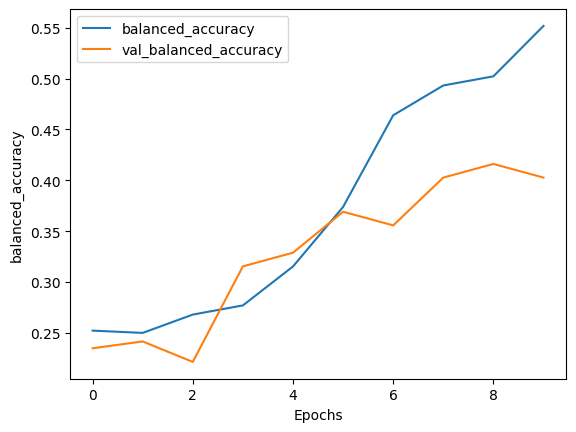

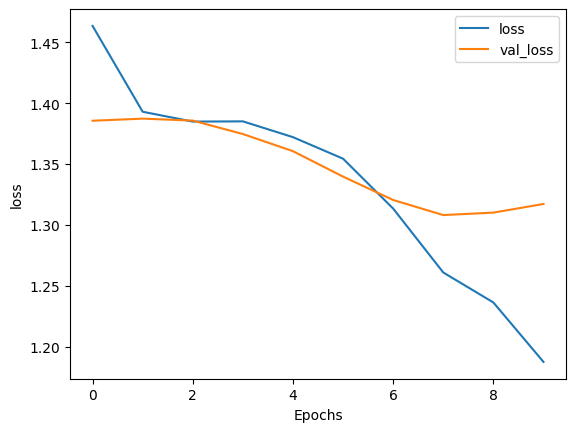

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_abs_lbert, "balanced_accuracy")
plot_graphs(history_abs_lbert, "loss")

In [ ]:
model_abs_lbert.save("/content/drive/MyDrive/Final Year Paper Work/H5 Files/ABS-LEGALBERT.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##**3) Extractive Summarized Data**

In [ ]:
# Tokenize the input (takes some time)
# here tokenizer using from bert-base-cased
x_train_ext_lbert = lbert_tokenizer(
    text=df_train_ext['Extractive Summarized Judgements'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test_ext_lbert = lbert_tokenizer(
    text=df_test_ext['Extractive Summarized Judgements'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids_ext_lbert = x_train_ext_lbert['input_ids']
attention_mask_ext_lbert = x_train_ext_lbert['attention_mask']

In [ ]:
max_len = 100

input_ids_ext_lbert = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask_ext_lbert = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = lbert_model(input_ids_ext_lbert, attention_mask = input_mask_ext_lbert)[0]
out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)

model_ext_lbert = tf.keras.Model(inputs=[input_ids_ext_lbert, input_mask_ext_lbert], outputs=y)
model_ext_lbert.layers[2].trainable = True

In [ ]:
optimizer_ext_lbert = tf.keras.optimizers.legacy.Adam(learning_rate=5e-05, # this learning rate is for legal bert model , taken from huggingface website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss_ext_lbert = CategoricalCrossentropy(from_logits = True)
metric_ext_lbert = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model_ext_lbert.compile(
    optimizer = optimizer_ext_lbert,
    loss=loss_ext_lbert,
    metrics = metric_ext_lbert)

In [ ]:
history_ext_lbert = model_ext_lbert.fit(
    x ={'input_ids':x_train_ext_lbert['input_ids'],'attention_mask':x_train_ext_lbert['attention_mask']} ,
    y = y_train_ext,
    validation_data = (
    {'input_ids':x_test_ext_lbert['input_ids'],'attention_mask':x_test_ext_lbert['attention_mask']}, y_test_ext
    ),
  epochs=10,
    batch_size=64
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 42s 2s/step - loss: 1.3782 - balanced_accuracy: 0.2995 - val_loss: 1.3730 - val_balanced_accuracy: 0.3087
Epoch 2/10
7/7 [==============================] - 10s 2s/step - loss: 1.3397 - balanced_accuracy: 0.3806 - val_loss: 1.3343 - val_balanced_accuracy: 0.4161
Epoch 3/10
7/7 [==============================] - 11s 2s/step - loss: 1.3165 - balanced_accuracy: 0.4302 - val_loss: 1.3309 - val_balanced_accuracy: 0.4027
Epoch 4/10
7/7 [==============================] - 10s 2s/step - loss: 1.3191 - balanced_accuracy: 0.4189 - val_loss: 1.3139 - val_balanced_accuracy: 0.3960
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 1.2780 - balanced_accuracy: 0.4662 - val_loss: 1.2901 - val_balanced_accuracy: 0.4161
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 1.2425 - balanced_accuracy: 0.4887 - val_loss: 1.2839 - val_balanced_accuracy: 0.4094
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 1.230

In [ ]:
predicted_raw_ext_lbert = model_ext_lbert.predict({'input_ids':x_test_ext_lbert['input_ids'],'attention_mask':x_test_ext_lbert['attention_mask']})
predicted_raw_ext_lbert[0]

5/5 [==============================] - 6s 213ms/step


array([0.6068629 , 0.67783654, 0.51827747, 0.45265755], dtype=float32)

In [ ]:
import numpy as np

y_predicted_ext_lbert = np.argmax(predicted_raw_ext_lbert, axis = 1)
y_true_ext_lbert = df_test_ext['Judgement Status']

In [ ]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_true_ext_lbert, y_predicted_ext_lbert))

print("F1 Score: ",f1_score(y_true_ext_lbert,y_predicted_ext_lbert, average='weighted'))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.40      0.91      0.55        45
           2       0.46      0.72      0.56        29
           3       0.00      0.00      0.00        36

    accuracy                           0.42       149
   macro avg       0.21      0.41      0.28       149
weighted avg       0.21      0.42      0.28       149

F1 Score:  0.27632504988209683


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
x_train_ext_lbert ={'input_ids':x_train_ext_lbert['input_ids'],'attention_mask':x_train_ext_lbert['attention_mask']}

train_loss_ext_lbert, train_accuracy_ext_lbert = model_ext_lbert.evaluate(x_train_ext_lbert, y_train_ext, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy_ext_lbert))

Training Accuracy: 0.5293


In [ ]:
x_test_ext_lbert = {'input_ids':x_test_ext_lbert['input_ids'],'attention_mask':x_test_ext_lbert['attention_mask']}

test_loss_ext_lbert, test_accuracy_ext_lbert = model_ext_lbert.evaluate(x_test_ext_lbert, y_test_ext, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_ext_lbert))

Testing Accuracy:  0.4161


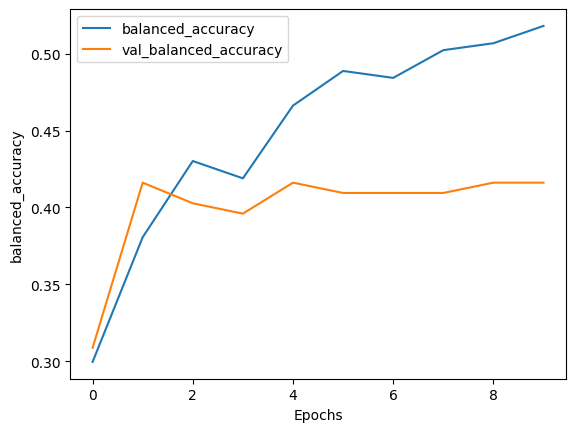

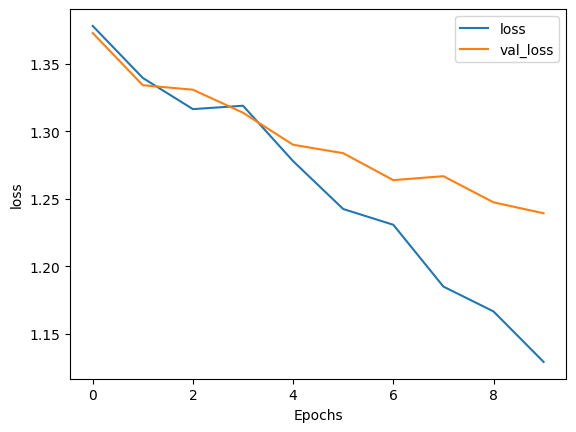

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history_ext_lbert, "balanced_accuracy")
plot_graphs(history_ext_lbert, "loss")

In [ ]:
model_ext_lbert.save("/content/drive/MyDrive/Final Year Paper Work/H5 Files/EXT-LEGALBERT.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
